# Модель машинного обучения для распознавания мошенничества среди карточных транзакций

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    average_precision_score, 
    roc_auc_score, 
    PrecisionRecallDisplay
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv("data/creditcard.csv")

## Предварительный анализ данных

In [3]:
print(f"Всего строк: {df.shape[0]}\nВсего столбцов: {df.shape[1]}")

Всего строк: 284807
Всего столбцов: 31


In [4]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<br>Time - секунды, прошедшие с момента первой зарегистрированной транзакции в наборе данных
<br>Amount - сумма транзакции
<br>Class - была ли транзакция мошеннической (1) или нет (0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Этот краткий обзор показывает отсутствие пропущенных значений среди всех атрибутов, поэтому не нужно будет иметь с ними дело. Кроме того, все столбцы отображают числа с плавающей запятой (float64), за исключением атрибута Class. Который, представлен в виде целого числа (int64), но на самом деле представляет категориальные данные (мошеннические или нет).
<br><br>
Одной из повторяющихся проблем, связанных с такого рода наборами данных, является их несбалансированный характер. То есть некоторые категории появляются гораздо чаще, чем другие. Вероятно, увидим гораздо больше обычных транзакций, чем мошеннических.

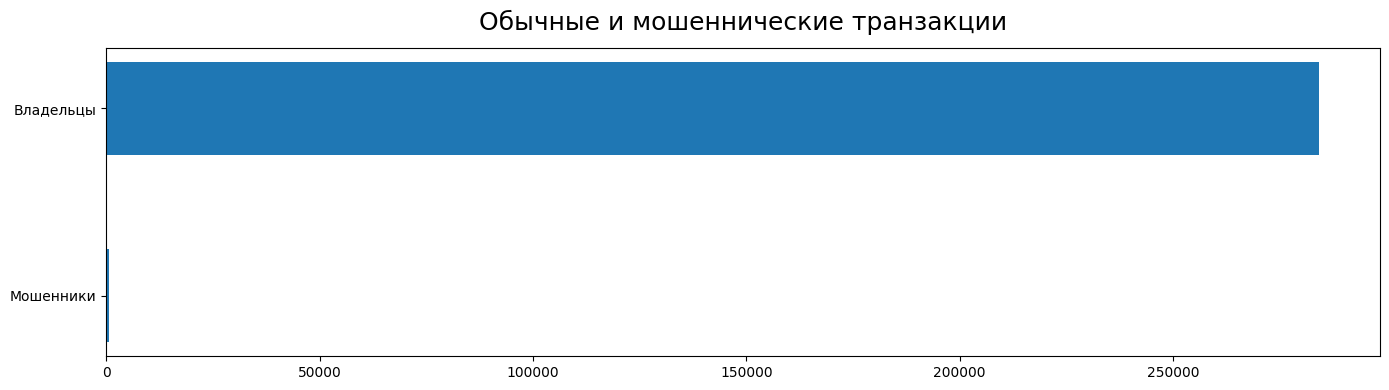

In [3]:
fig, ax = plt.subplots(figsize=(14, 4))

labels = ["Мошенники", "Владельцы"]
values = [df.Class.value_counts()[1], df.Class.value_counts()[0]]

ax.set_title("Обычные и мошеннические транзакции", fontsize=18, y=1.03)
plt.barh(labels, values, height=0.5)

plt.tight_layout()
plt.savefig('1.png')

In [7]:
print(f"Всего нормальный транзакций: {values[1]}\nВсего мощеннических транзакций:{values[0]}")
print(f"Процент мошенничества: {values[0]/df.shape[0]*100:.3}%")

Всего нормальный транзакций: 284315
Всего мощеннических транзакций:492
Процент мошенничества: 0.173%


В наборе данных зарегистрировано всего 492 мошенничества, что составляет примерно 0,173% от всех данных. Это наглядный пример дисбаланса, о котором я упоминал ранее, и позже я использую несколько методов, позволяющих уменьшить это несоответствие.

## Распределение данных 

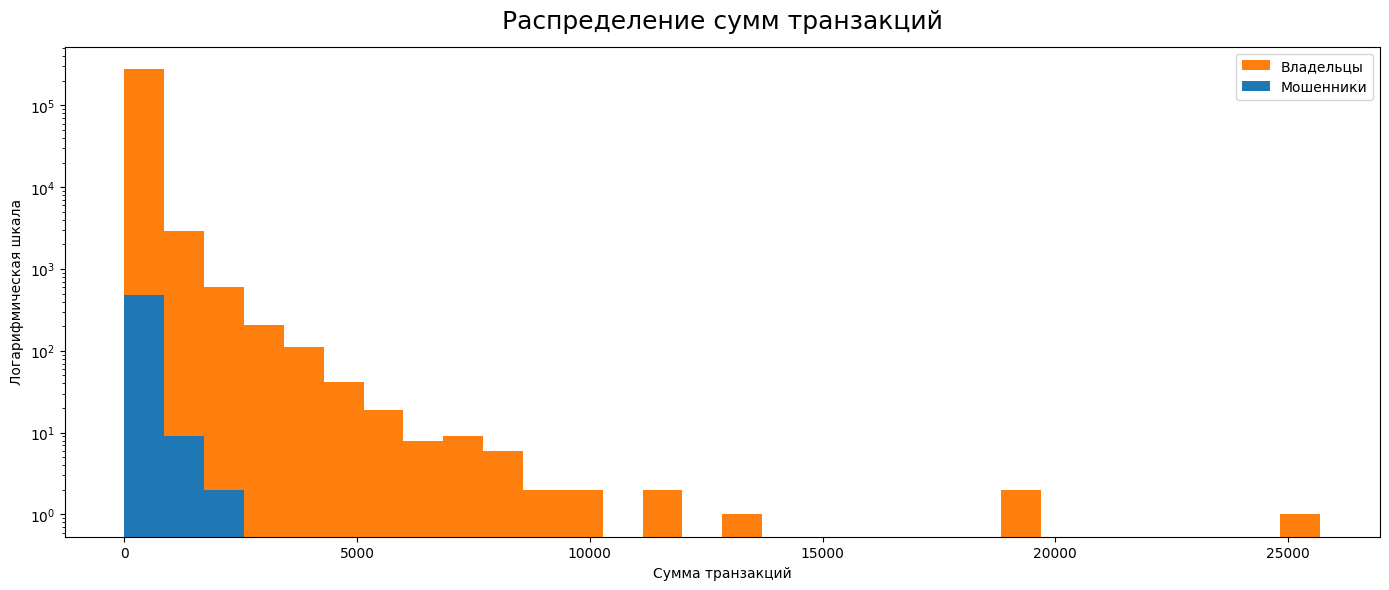

In [4]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.histplot(data=df, x="Amount", bins=30, hue=df.Class, ax=ax, alpha=1.0, hue_order=[1, 0], linewidth=0)
ax.set_title("Распределение сумм транзакций", fontsize=18, y=1.02)
ax.set_ylabel("Логарифмическая шкала")
ax.set_xlabel("Сумма транзакций")
ax.legend(["Владельцы", "Мошенники"])

plt.yscale("log")
plt.tight_layout()
plt.savefig('2.png')


Распределение по свойству Amount показывает, что большинство мошенничеств происходит с наименьшей суммой транзакции. Строго рассматривая эту переменную, могли бы сказать, например, что любая транзакция с суммой, превышающей 5000, вероятно, реальна. Но пока не будем делать поспешных выводов.

In [9]:
print(f"Общее время: {df.Time.max():.0f} секунд или {df.Time.max()/3600:.2f} часов")

Общее время: 172792 секунд или 48.00 часов


## Подготовка данных

In [10]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Во многих моделях машинного обучения одни могут лучше справляться с такого рода данными, а другие - нет. Быстрым решением этой проблемы является обработка этих данных с помощью некоторого преобразования.
<br><br>
Стандартизируем переменные времени и суммы. То есть приведём их оба к одной шкале, где стандартное отклонение равно 1.
<br>
Для этого вычтем из каждого значения его среднее значение, а затем разделим на стандартное отклонение.

In [11]:
df.Time = (df.Time - df.Time.mean()) / df.Time.std()
df.Amount = (df.Amount - df.Amount.mean()) / df.Amount.std()

In [12]:
X = df.drop(axis=1,columns=["Class"])
y = df.Class
X.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,-6.386744e-18,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,3.193372e-17
std,1.000000e+00,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,1.000000e+00
min,-1.996580e+00,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-3.532288e-01
25%,-8.552105e-01,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-3.308395e-01
50%,-2.131450e-01,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-2.652710e-01
75%,9.372158e-01,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-4.471699e-02
max,1.642055e+00,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.023621e+02


In [13]:
scaler = StandardScaler()
scaler.fit_transform(X);

Создание обучающего и испытательного набора данных.<br><br>80% от исходного набора данных на обучение, остальные 20% на тестирование.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Теперь, с помощью серии преобразований, я попытаюсь повысить производительность модели с помощью более сбалансированного набора данных.
<br><br>
Среди множества доступных методов я выбрал SMOTE (Synthetic Minority Oversampling Technique) для избыточной выборки и Random Under Sampler для недостаточной выборки.

In [15]:
over = SMOTE(sampling_strategy=0.1,random_state=0)
under = RandomUnderSampler(sampling_strategy=0.5,random_state=0)

pipeline = Pipeline(steps=[("over", over), ("under", under)])

До трансформации набора данных.

In [16]:
example = [i for i in y.value_counts()]
print(f"Всего нормальный транзакций: {example[0]}\nВсего мощеннических транзакций:{example[1]}")
print(f"Процент мошенничества:  {example[1]/(example[1]+example[0])*100:.2f}%")

Всего нормальный транзакций: 284315
Всего мощеннических транзакций:492
Процент мошенничества:  0.17%


In [17]:
X_train, y_train = pipeline.fit_resample(X_train,y_train)

После трансформации набора данных.

In [18]:
example = [i for i in y_train.value_counts()]
print(f"Всего нормальный транзакций: {example[0]}\nВсего мощеннических транзакций: {example[1]}")
print(f"Процент мошенничества: {example[1]/(example[1]+example[0])*100:.2f}%")

Всего нормальный транзакций: 45490
Всего мощеннических транзакций: 22745
Процент мошенничества: 33.33%


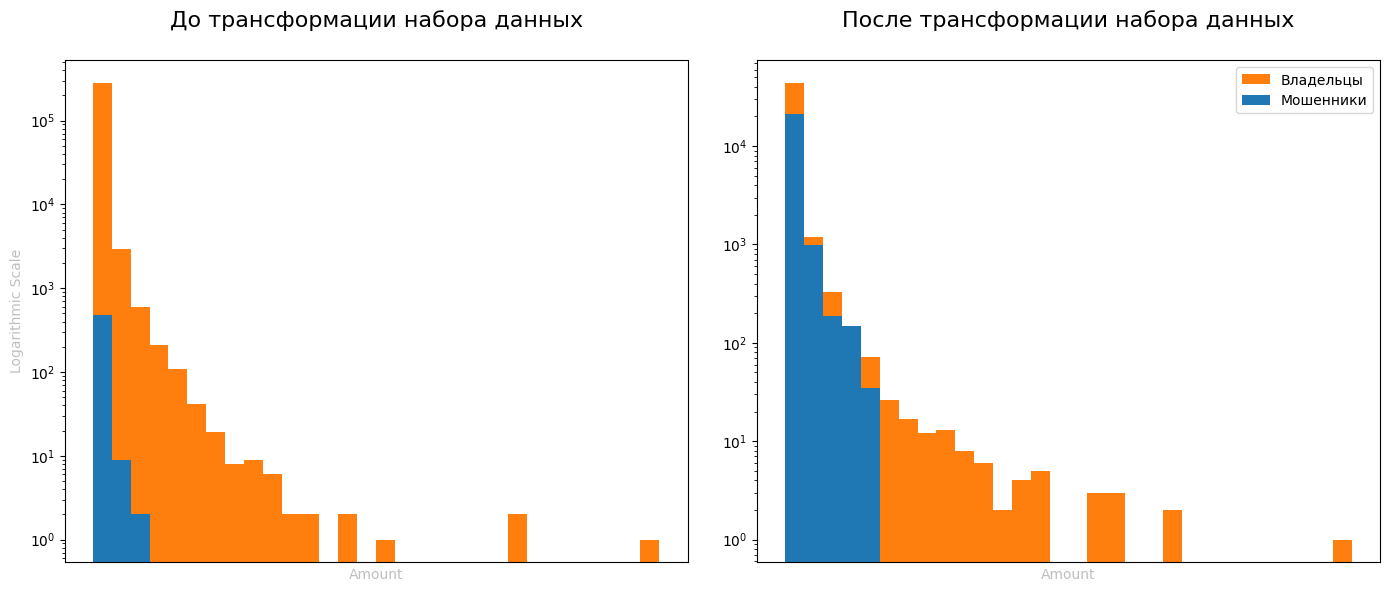

In [50]:
fig,(ax1,ax2) = plt.subplots(figsize=(14,6),nrows=1,ncols=2)
example_df = X_train.copy().merge(y_train.rename('Class'), left_index=True, right_index=True)

ax1.set_title("До трансформации набора данных", fontsize=16,y=1.05)
sns.histplot(data = df, x="Amount", bins=30,hue=df.Class,ax=ax1,alpha=1.0,hue_order=[1,0],linewidth=0,legend=False)
ax1.set_ylabel("Logarithmic Scale", c = "#BFBFBF")
ax1.set_xlabel("Amount", c = "#BFBFBF")
ax1.set_yscale("log")
ax1.set_xticks([])

ax2.set_title("После трансформации набора данных", fontsize=16,y=1.05)
sns.histplot(data = example_df, x="Amount",bins=30,hue="Class",ax=ax2,alpha=1.0,hue_order=[1,0],linewidth=0)
ax2.legend(["Владельцы", "Мошенники"])
ax2.set_ylabel(" ")
ax2.set_xlabel("Amount", c = "#BFBFBF")
ax2.set_yscale("log")
ax2.set_xticks([])

plt.tight_layout()
plt.savefig('3.png')

## Обучение модели (Random Forest) 

In [52]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [59]:
start=datetime.now()
y_pred = model.predict(X_test)

print(f"Всего ушло времени на прогноз: {(datetime.now()-start).seconds}.{(datetime.now()-start).microseconds/10000:.0f} секунд\n")

X_test.info(verbose=False)

Всего ушло времени на прогноз: 0.58 секунд

<class 'pandas.core.frame.DataFrame'>
Index: 56962 entries, 183484 to 246221
Columns: 30 entries, Time to Amount
dtypes: float64(30)
memory usage: 13.5 MB


Прогнозирование заняло 0,58 секунд. Это значение хорошее и представляет собой прогноз для большого объема данных, 13,5 МБ тестового набора, а для реальных приложений оцениваемый набор данных был бы намного меньше, а значит, и время выполнения.

In [61]:
print(f"Общая точность модели: {accuracy_score(y_test, y_pred)*100:.2f}%")

Общая точность модели: 99.92%


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.72      0.86      0.79       101

    accuracy                           1.00     56962
   macro avg       0.86      0.93      0.89     56962
weighted avg       1.00      1.00      1.00     56962



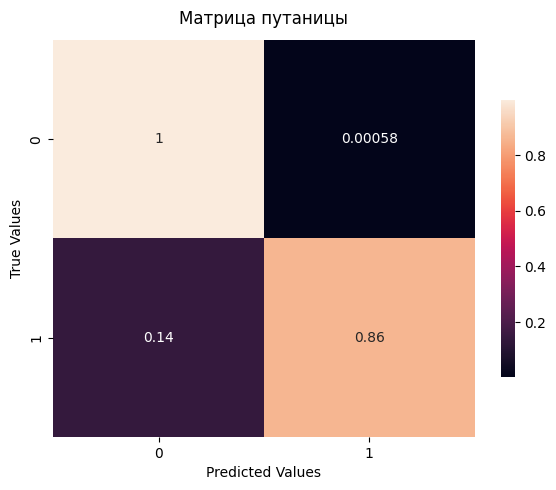

In [63]:
fig, ax = plt.subplots(figsize=(6,5))

norm_conf = [i for i in confusion_matrix(y_test,y_pred)]
norm_conf[0] = norm_conf[0] / norm_conf[0].sum()
norm_conf[1] = norm_conf[1] / norm_conf[1].sum()
sns.color_palette("magma", as_cmap=True)
sns.heatmap(data=norm_conf, annot=True,ax=ax,cbar_kws={"shrink": .7})
ax.set_title("Матрица ошибок",y=1.02)
ax.set_ylabel("True Values")
ax.set_xlabel("Predicted Values")

plt.tight_layout()
print(classification_report(y_test,y_pred))

In [67]:
print(f"Оценка ROC AUC: {roc_auc_score(y_test,y_pred):.2f}")

ROC AUC Score: 0.93


Средняя точность: 0.62



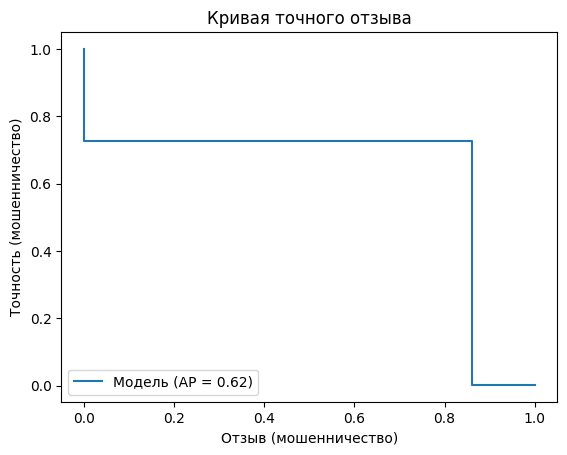

In [70]:
display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="Модель")
_ = display.ax_.set_title("Кривая точного отзыва")
_ = display.ax_.set_xlabel("Отзыв (мошенничество)")
_ = display.ax_.set_ylabel("Точность (мошенничество)")

print(f"Средняя точность: {average_precision_score(y_test,y_pred):.2f}\n")

В этой модели удалось идентифицировать алгоритм случайного леса как эффективный способ классификации мошеннических транзакций по кредитным картам. 

Чтобы устранить дисбаланс, к обучающему набору были применены 2 метода: SMOTE и Random Under Sampler. С их помощью первоначальный дисбаланс в 0,17% по мошенническим транзакциям был преобразован в 33%.

Устранение дисбаланса эффективно улучшило производительность модели, но также увеличило количество ложноположительных результатов. Из-за характера проблемы этот результат оправдан, поскольку желательно лучше выявлять мошенничество, чтобы избежать еще нескольких ложных срабатываний.